In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [31]:
df = pd.read_csv('data/ml-ready/final/daily-data-ml-ready.csv')
print(df)
df.shape

        id   Latitude  Longitude  Date Local  AQI  Population  White Alone  \
0      353  33.553056    -86.815  12/31/2022   34    5.057529   360.819272   
1      352  33.553056    -86.815  12/30/2022   33    4.908779   350.206940   
2      351  33.553056    -86.815  12/29/2022   41    6.098785   435.105593   
3      350  33.553056    -86.815  12/28/2022   40    5.950035   424.493261   
4      349  33.553056    -86.815  12/27/2022   34    5.057529   360.819272   
...    ...        ...        ...         ...  ...         ...          ...   
14871    4  33.553056    -86.815    1/5/2014   22    3.339233   188.679245   
14872    3  33.553056    -86.815    1/4/2014   21    3.187449   180.102916   
14873    2  33.553056    -86.815    1/3/2014   27    4.098149   231.560892   
14874    1  33.553056    -86.815    1/2/2014   26    3.946366   222.984563   
14875    0  33.553056    -86.815    1/1/2014   19    2.883883   162.950257   

       Hispanic/Latino  Black or African American Alone  \
0   

(14876, 11)

In [11]:
df.keys()

Index(['id', 'Latitude', 'Longitude', 'Date Local', 'AQI', 'Population',
       'White Alone', 'Hispanic/Latino', 'Black or African American Alone',
       'Asian/Pacific Islander', 'Some Other Race Alone'],
      dtype='object')

In [12]:
df.describe()

,id,Latitude,Longitude,AQI,Population,White Alone,Hispanic/Latino,Black or African American Alone,Asian/Pacific Islander,Some Other Race Alone
count,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000
mean,832.357623,33.539371,-86.832212,38.674173,5.843130,338.894715,110.187890,4176.793908,55704.135707,362.543975
std,488.251579,0.136814,0.138296,14.010094,2.120284,124.372737,41.705272,1649.810265,39606.281690,133.138725
min,0.000000,33.331111,-87.003611,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,413.000000,33.485556,-86.942500,30.000000,4.553499,264.247336,84.219645,3076.923077,30303.030300,278.444551
50%,826.000000,33.545278,-86.816667,38.000000,5.705525,330.888929,105.876125,3958.529689,42424.242420,351.308625
75%,1239.000000,33.578333,-86.773889,44.000000,6.680686,392.190298,128.508426,5024.519737,67692.307690,422.336931
max,1873.000000,33.801667,-86.549167,156.000000,23.640232,1330.036661,459.360645,16352.201260,362068.965500,1457.159510


In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Preprocess the data
features = df.drop(columns=['id', 'Latitude', 'Longitude', 'Date Local','AQI']).values

target = df['AQI'].values

# Normalize the features
feature_scaler = StandardScaler()
features_scaled = feature_scaler.fit_transform(features)

# Create sequences for LSTM
def create_sequences(data, target, sequence_length=5):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

sequence_length = 15 # You can adjust the sequence length
X, y = create_sequences(features_scaled, target, sequence_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the CNN-LSTM model
class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=X_train.shape[2], out_channels=64, kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=2)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=100, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=100, hidden_size=50, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(50, 25)
        self.fc2 = nn.Linear(25, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, num_features, sequence_length)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)  # Change shape back to (batch_size, sequence_length, num_features)
        x, (hn, cn) = self.lstm1(x)
        x, (hn, cn) = self.lstm2(x)
        x = self.dropout(x[:, -1, :])
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = CNN_LSTM()

In [8]:
# Define loss and optimizer
criterion = nn.MSELoss() #1/n(y_hat - y)squared
# criterion = nn.SmoothL1Loss()  # Huber loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses = []
val_losses = []

# Training loop
num_epochs = 150
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            val_loss += loss.item()

    # val_loss /= len(test_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(test_loader):.4f}')

# Evaluate the model
model.eval()
test_loss = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        test_loss += loss.item()
print(f'Test Loss: {test_loss/len(test_loader):.4f}')

# Predict future AQI values
model.eval()
with torch.no_grad():
    predictions = model(X_test).squeeze().numpy()
print(predictions)

Epoch 1/150, Train Loss: 1375.9016, Val Loss: 994.3213
Epoch 2/150, Train Loss: 701.2329, Val Loss: 440.2129
Epoch 3/150, Train Loss: 329.6190, Val Loss: 224.1197
Epoch 4/150, Train Loss: 227.2522, Val Loss: 158.4751
Epoch 5/150, Train Loss: 163.7368, Val Loss: 116.0673
Epoch 6/150, Train Loss: 136.6071, Val Loss: 95.8257
Epoch 7/150, Train Loss: 125.1198, Val Loss: 84.4156
Epoch 8/150, Train Loss: 115.6710, Val Loss: 77.6779
Epoch 9/150, Train Loss: 111.7513, Val Loss: 74.7137
Epoch 10/150, Train Loss: 108.2631, Val Loss: 71.5987
Epoch 11/150, Train Loss: 105.6778, Val Loss: 70.7968
Epoch 12/150, Train Loss: 105.3262, Val Loss: 67.4410
Epoch 13/150, Train Loss: 103.6298, Val Loss: 67.4503
Epoch 14/150, Train Loss: 102.1381, Val Loss: 66.1161
Epoch 15/150, Train Loss: 98.4918, Val Loss: 66.2788
Epoch 16/150, Train Loss: 97.6774, Val Loss: 64.8159
Epoch 17/150, Train Loss: 99.0517, Val Loss: 69.1171
Epoch 18/150, Train Loss: 97.3101, Val Loss: 64.8734
Epoch 19/150, Train Loss: 97.1591, 

In [9]:
print(predictions)

[50.285362 26.273592 24.12963  ... 37.91974  34.690567 40.954197]


In [10]:
print(y_test)

tensor([47., 26., 25.,  ..., 39., 54., 44.])


In [52]:
# Save the trained model
torch.save(model.state_dict(), 'best_model.pth')

In [5]:
# Function to load the model
def load_model(filepath):
    model = CNN_LSTM()
    model.load_state_dict(torch.load(filepath))
    return model

# Load the saved model (example usage)
loaded_model = load_model('best_model.pth')

NameError: name 'CNN_LSTM' is not defined

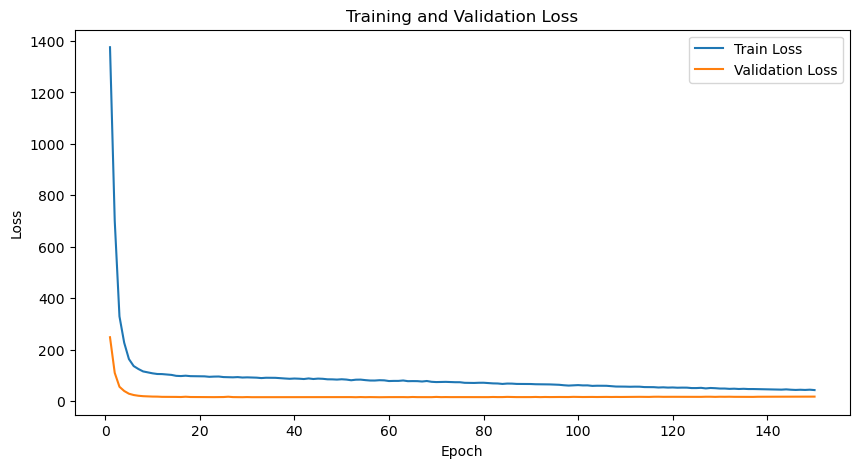

In [11]:
train_losses_scaled = [x/len(train_loader) for x in train_losses]
val_losses_scaled = [x/len(train_loader) for x in val_losses]

# Plot the training and validation loss
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses_scaled, label='Train Loss')
plt.plot(epochs, val_losses_scaled, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
true_values = np.array(y_test)

# Calculate performance metrics
mse = mean_squared_error(true_values, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values, predictions)
r2 = r2_score(true_values, predictions)

# Define a tolerance level for custom accuracy
tolerance = 0.3  # 30% tolerance
accuracy = np.mean(np.abs(predictions - true_values) / true_values < tolerance) * 100

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')
print(f'Accuracy: {accuracy:.2f}%')

MSE: 70.9535
RMSE: 8.4234
MAE: 5.3210
R²: 0.6207
Accuracy: 88.73%


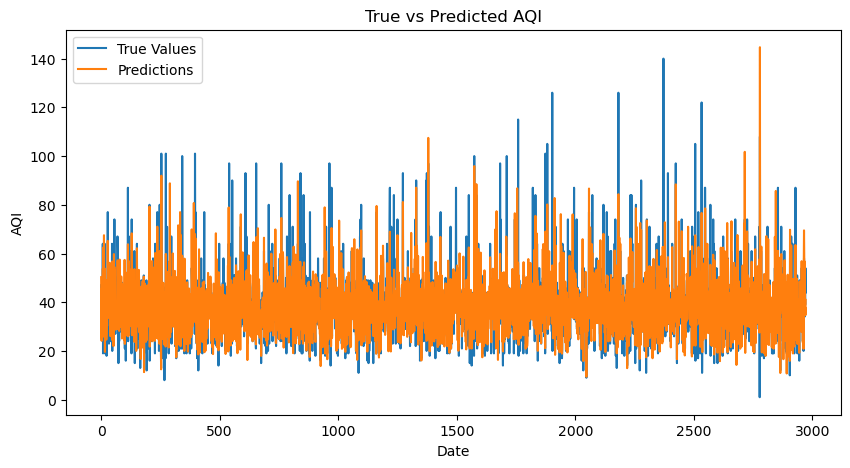

In [34]:
# Visualize predictions
plt.figure(figsize=(10, 5))
plt.plot(true_values, label='True Values')
plt.plot(predictions, label='Predictions')
plt.xlabel('Date')
# Set x-axis limits and ticks
ax.set_xlim(min(group_years_seq), max(group_years_seq))  # Set limits based on actual data range

# Set x-axis ticks at yearly intervals
interval = 2000
ax.set_xticks(group_years_seq[::interval])  # Use group_years_seq directly for ticks

# Rotate x-axis labels for better readability
plt.setp(ax.get_xticklabels(), rotation=0, ha="right")

plt.ylabel('AQI')
plt.title('True vs Predicted AQI')
plt.legend()
plt.show()

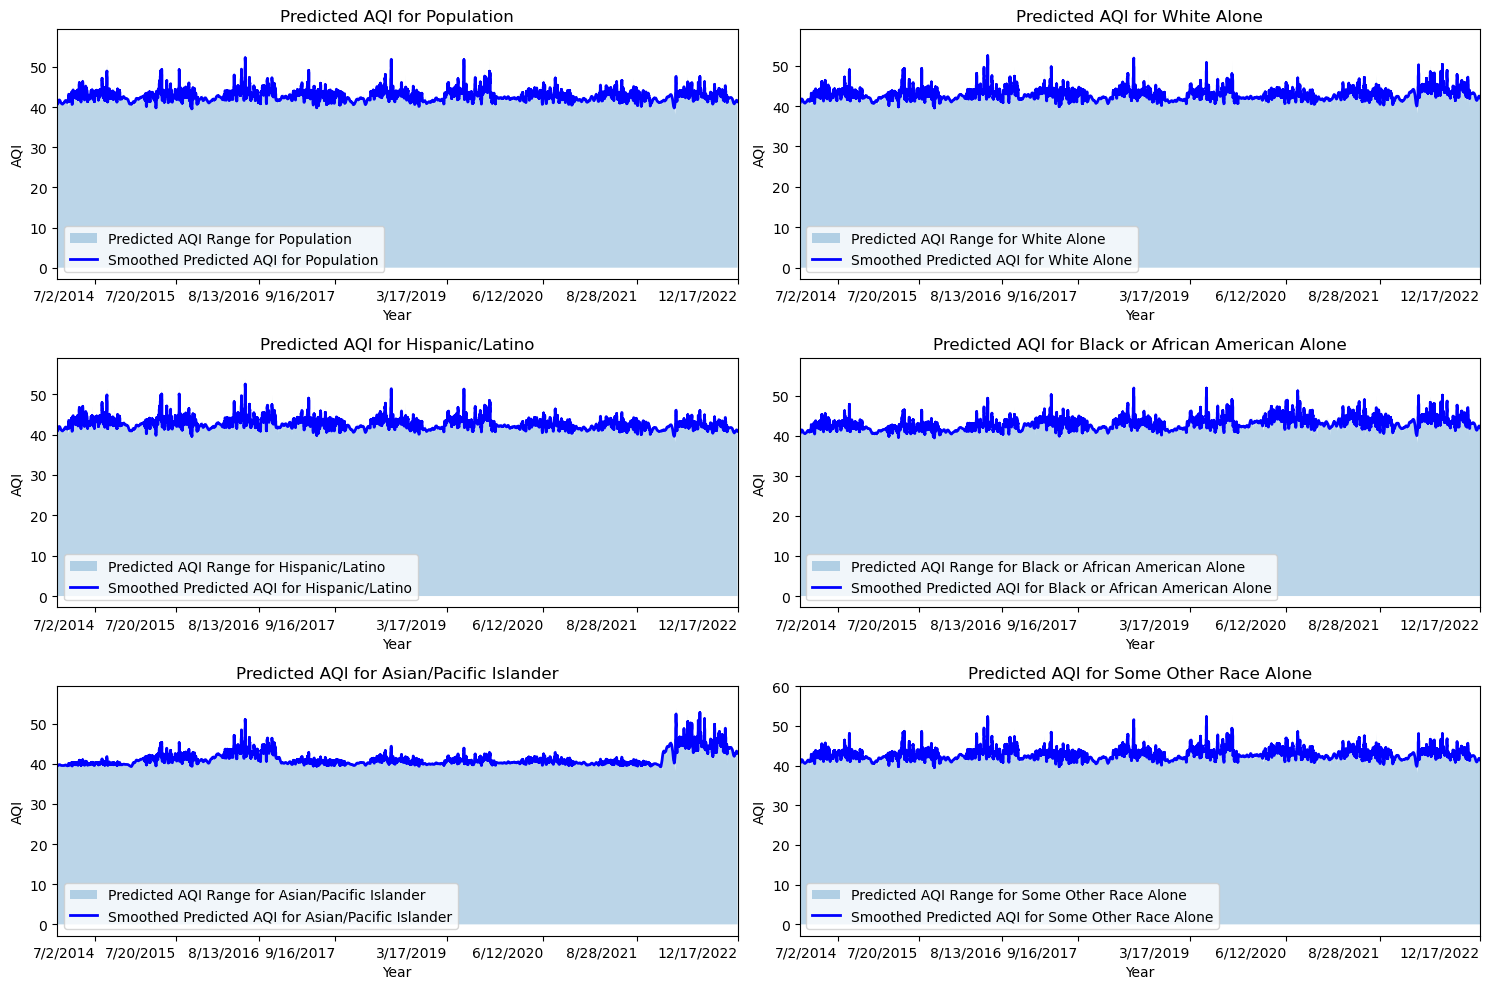

In [63]:
# Analyze results for different racial population communities
racial_groups = ['Population','White Alone', 'Hispanic/Latino', 'Black or African American Alone',
       'Asian/Pacific Islander', 'Some Other Race Alone']  # Replace with actual column names
# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

for idx, group in enumerate(racial_groups):
    group_features = df[[group]].values
    group_scaler = MinMaxScaler()
    group_features_scaled = group_scaler.fit_transform(group_features)
    
    # Duplicate the single feature to match the input channels expected by the model
    group_features_scaled = np.repeat(group_features_scaled, repeats=X_train.shape[2], axis=1)
    
    # Create sequences for the duplicated features and corresponding years
    group_features_seq = []
    group_years_seq = []
    for i in range(len(group_features_scaled) - sequence_length + 1):
        group_features_seq.append(group_features_scaled[i:i + sequence_length])
        group_years_seq.append(df['Date Local'].values[i + sequence_length - 1])
    
    group_features_seq = np.array(group_features_seq)
    group_features_seq = torch.tensor(group_features_seq, dtype=torch.float32)

    # group_years_seq = np.array(group_years_seq)
    
    model.eval()
    group_predictions = []
    with torch.no_grad():
        for batch in group_features_seq:
            batch = batch.unsqueeze(0)  # Add batch dimension
            outputs = model(batch)
            group_predictions.extend(outputs.tolist())
    
    group_predictions = np.array(group_predictions).flatten()

    smoothed_predictions = pd.Series(group_predictions).rolling(window=10, min_periods=1).mean().values
    
    # Plotting in the corresponding subplot as an area plot
    ax = axes[idx]
    ax.fill_between(group_years_seq, group_predictions, alpha=0.3, label=f'Predicted AQI Range for {group}')
    ax.plot(group_years_seq, smoothed_predictions, color='blue', linewidth=2, label=f'Smoothed Predicted AQI for {group}')
    ax.set_xlabel('Year')
    ax.set_ylabel('AQI')
    ax.set_title(f'Predicted AQI for {group}')
    ax.legend()

    # Set x-axis limits and ticks
    ax.set_xlim(min(group_years_seq), max(group_years_seq))  # Set limits based on actual data range

    # Set x-axis ticks at yearly intervals
    interval = 2000
    ax.set_xticks(group_years_seq[::interval])  # Use group_years_seq directly for ticks

    # Rotate x-axis labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right")

    # Display legend
    ax.legend()

plt.tight_layout()
plt.show()